# Play Shakespeare in Python

* 数据: 莎士比亚作品 [xml格式](https://github.com/severdia/PlayShakespeare.com-XML) (感谢severdia分享)
    * 此xml数据比较规整, 且有不少除剧本台词之外的信息, 例如 meta data 有关题材分类Genre等
* 处理 xml 文件转化为 DataFrame
* 从人物台词推测出自悲剧/喜剧/历史剧
* 假设未有 genre, 尝试聚类
* 词云可视化呈现

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.graphics.api as smg
import patsy
from sklearn import cross_validation
from sklearn import linear_model
from sklearn import metrics
from sklearn import tree
from sklearn import neighbors
from sklearn import svm
from sklearn import ensemble
from sklearn import cluster

## 处理 xml 文件 转化为 dataframe

* 使用 lxml/xml 等工具解析
* 探索过程详见 `how-to-convert-xml-to-pandas-dataframe.ipynb`

In [3]:
# -*- coding: utf-8 -*-
'''
convert shakespeare xml to dataframe
@author: bambooom
'''

from lxml import objectify
import xml.etree.ElementTree as etree
import lxml.etree
import pandas as pd
import numpy as np
import os

def xml2df():
    file_list = []
    # walk down into folder to get the list of all xml files
    for dirpath, dirs, files in os.walk('text_Data_xml'):
        file_list.append(files)

    file_list = np.ravel(file_list) # flatten

    speeches = []
    plays_name = []
    genre_list = []
    speakers = []

    # for each xml file
    for file_name in file_list:
        path = 'text_data_xml/%s'% file_name
        tree = etree.parse(path)
        root = tree.getroot()
        xml = objectify.parse(open(path))
        root_xml = xml.getroot()

        for e in root_xml.getchildren():
            if e.tag == 'act':
                for ee in e.getchildren():
                    if ee.tag == 'scene':
                        for eee in ee.getchildren():
                            if eee.tag == 'speech': # find speech element to extract all lines
                                name = unicode(root_xml.getchildren()[0].text.encode('utf-8'), "utf-8")
                                gen = root.attrib['genre']

                                speakers.append(str(eee.getchildren()[0]))
                                plays_name.append(name)
                                genre_list.append(gen)
                                for i in eee.getchildren()[1:]:
                                    if i.text is not None:
                                        lines = ''.join(unicode(i.text.encode('utf-8'),'utf-8'))
                                    else:
                                        continue
                                speeches.append(lines)

    d = {'speeches':speeches, 'plays_name':plays_name,
        'genre':genre_list, 'speakers':speakers}
    speech_all = pd.DataFrame(d)

    return speech_all

In [4]:
speech_all = xml2df()

**Note:** 有关 xml 转为 dataframe, 中间遇到两个问题:
* 一个是对`lxml/xml`运用不熟练, 现在的做法只是循环套循环, 比较繁琐, 是否有更简单的方法呢? 
* 二就是有关编码问题.....英文都有, 如果要运用到中文上, 更有可能存在问题.

另外, 莎翁作品一般分为的是四类, 但`诗/poem`格式较特殊, 与其他三种不一样, 以上转化暂时将`诗/poem`去掉.

In [5]:
speech_all.info() #没有缺失值

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33447 entries, 0 to 33446
Data columns (total 4 columns):
genre         33447 non-null object
plays_name    33447 non-null object
speakers      33447 non-null object
speeches      33447 non-null object
dtypes: object(4)
memory usage: 1.3+ MB


## 台词推测悲剧/喜剧/历史剧

参考:
* [Building a Genre Classifier for Shakespeare Speeches](http://www.adampalay.com/notebooks/shakespeare-genre-classifier.html)
* [Text Mining the Complete Works of William Shakespeare](http://www.r-bloggers.com/text-mining-the-complete-works-of-william-shakespeare/)

参考 `sklearn` 中如何处理文本数据
* http://scikit-learn.org/stable/modules/feature_extraction.html
* http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

另外需要处理文本数据的话, 可以用到 `nltk` 这个包, 参考
* [nltk 官网](http://www.nltk.org/)
* [Natural Language Processing with Python](http://www.nltk.org/book/)
* [demo](http://text-processing.com/demo/)

In [6]:
speech_all.head()

,genre,plays_name,speakers,speeches
0,comedy,All’s Well That Ends Well,COUNT.,"In delivering my son from me, I bury a second ..."
1,comedy,All’s Well That Ends Well,BER.,"And I in going, madam, weep o’er my father’s d..."
2,comedy,All’s Well That Ends Well,LAF.,"You shall find of the King a husband, madam; y..."
3,comedy,All’s Well That Ends Well,COUNT.,What hope is there of his Majesty’s amendment?
4,comedy,All’s Well That Ends Well,LAF.,"He hath abandon’d his physicians, madam, under..."


In [7]:
# classification 仅用到 genre 和 speeches 两列数据
X_all = speech_all.speeches
Y_all = speech_all.genre

In [8]:
# split train, test, 80% 为 train, 20% 留存为 test
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X_all, Y_all, train_size=0.8)

In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [10]:
# 计算词频
count_vec = CountVectorizer()
X_train_counts = count_vec.fit_transform(X_train)
X_train_counts.shape
# 26757 行数为总共多少句台词, 也就是 document 数量, 13321列数为分词后总共有这么多个单词

(26757, 13321)

In [11]:
# 一个巨大的 matrix
# 可以用 vocabulary_ 查看分词后的单词的 index
count_vec.vocabulary_.get(u'love')

6928

In [12]:
# 用 TfidfTransformer 转化词频数为 TF-IDF matrix
# term frequency * inverse document frequency
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(26757, 13321)

In [13]:
# 使用 multinomial variant in naive bayes 进行分类
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train_tfidf, Y_train)

In [15]:
# 对 test data 处理为 tfidf, 进行 predict
X_test_counts = count_vec.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
X_test_tfidf.shape

(6690, 13321)

In [16]:
Y_predicted = clf.predict(X_test_tfidf)

In [17]:
np.mean(Y_predicted == Y_test)

0.53811659192825112

In [18]:
# MultinomialNB准确率不是太高, 换linear SVM, 被认为是 best text classification algorithm
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier().fit(X_train_tfidf, Y_train)

In [21]:
Y_predicted_svm = sgd.predict(X_test_tfidf)

In [22]:
np.mean(Y_predicted_svm == Y_test)

0.56292974588938716

linear SVM 比 MultinomialNB 准确率略有提升.

In [23]:
# 尝试使用 stermming 参考Adam 做法
import nltk
from nltk.stem import PorterStemmer
import string

stemmer = PorterStemmer()
def tokenize_and_stem(text):
    tokens = nltk.tokenize.word_tokenize(text)
    # strip out punctuation and make lowercase
    tokens = [token.lower().strip(string.punctuation)
              for token in tokens if token.isalnum()]

    # now stem the tokens
    tokens = [stemmer.stem(token) for token in tokens]

    return tokens

In [24]:
# 加上 tokenizer 的词频
count_vec_token = CountVectorizer(tokenizer = tokenize_and_stem)

In [37]:
# note: 'tokenizers/punkt/english.pickle' tokenizer会需要用到 nltk 的这个 data, 需要提前下载
# http://stackoverflow.com/questions/26570944/resource-utokenizers-punkt-english-pickle-not-found
# 再次使用 MultinomialNB
X_train_tokenized = count_vec_token.fit_transform(X_train)

mnb = MultinomialNB()
mnb = mnb.fit(X_train_tokenized, Y_train)

In [39]:
X_test_tokenized = count_vec_token.transform(X_test)
Y_predicted_mnb = mnb.predict(X_test_tokenized)

In [40]:
np.mean(Y_predicted_mnb == Y_test)

0.55052316890881914

使用 tokenizer 之后的 MultinomialNB 比没有使用之前的准确率略有提升

In [27]:
# grid search to determine parameters

from sklearn.grid_search import GridSearchCV
parameters = {'vect__ngram_range': [(1, 1), (1, 2)],
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-1, 1e-3),}

In [28]:
from sklearn.pipeline import Pipeline

text_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='hinge', penalty='l2',
                                           alpha=1e-3, n_iter=5, random_state=42)),])

In [29]:
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)

In [30]:
gs_clf = gs_clf.fit(X_train[:10000],Y_train[:10000])

In [31]:
best_parameters, score, _ = max(gs_clf.grid_scores_, key=lambda x: x[1])

In [32]:
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

clf__alpha: 0.001
tfidf__use_idf: True
vect__ngram_range: (1, 1)


In [33]:
Y_predicted_gs = gs_clf.predict(X_test)

In [34]:
np.mean(Y_predicted_gs==Y_test)

0.51644245142002987

额 grid search 后分类效果反而变差.....why?

## 假设不知道 genre 进行聚类

In [35]:
# cluster 主要使用 Kmeans 和 minibatch Kmeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans, MiniBatchKMeans

In [47]:
# min_df = 0.001 说明去掉 document freq 小于0.001的词
tfidf_vectorizer = TfidfVectorizer(max_features=200000,
                                 min_df=0.001, stop_words='english',
                                 use_idf=True, ngram_range=(1,2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_train_tfidf.shape
# 余下 doc freq 高于0.001的词, 有763个

(26757, 763)

In [48]:
from sklearn.preprocessing import Normalizer

# 使用 truncated SVD 降维
# 常用于 Latent Semantic Analysis 潜在语义分析

svd = TruncatedSVD(100) # desired dimensionality, for LSA, 100 better
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [49]:
X_train_tfidf = lsa.fit_transform(X_train_tfidf)
svd.explained_variance_ratio_.sum() # explained variance of SVD step

0.42536508086505809

In [50]:
X_train_tfidf.shape # 在 svd 之后就只有100个了

(26757, 100)

In [57]:
true_k = 3 # 实际有3种分类
km = KMeans(n_clusters = true_k, init='k-means++', n_init=1, max_iter=50000)

km.fit(X_train_tfidf)

KMeans(copy_x=True, init='k-means++', max_iter=50000, n_clusters=3, n_init=1,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [58]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Y_train, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(Y_train, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(Y_train, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(Y_train, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train_tfidf, km.labels_, sample_size=1000))


Homogeneity: 0.003
Completeness: 0.015
V-measure: 0.005
Adjusted Rand-Index: 0.004
Silhouette Coefficient: 0.076


聚类结果并不好.  
Homogeneity, Completeness, V-measure, Adjusted Rand-Index 的结果越接近于1则表示 cluster 效果好.  
而 Silhouette Coefficient 接近于0 表示有重合 overlapping cluster

In [59]:
# 尝试 minibatch kmeans

minikm = MiniBatchKMeans(n_clusters=true_k, init='k-means++', n_init=1,
                         init_size=1000, batch_size=1000, max_iter=50000)
minikm.fit(X_train_tfidf)

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=1000, max_iter=50000, max_no_improvement=10,
        n_clusters=3, n_init=1, random_state=None, reassignment_ratio=0.01,
        tol=0.0, verbose=0)

In [60]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(Y_train, minikm.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(Y_train, minikm.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(Y_train, minikm.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(Y_train, minikm.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X_train_tfidf, minikm.labels_, sample_size=1000))


Homogeneity: 0.000
Completeness: 0.001
V-measure: 0.000
Adjusted Rand-Index: 0.000
Silhouette Coefficient: 0.055


和 K means 情况类似, cluster 效果不好.

## Visualization

In [71]:
# 前面是对每一句台词都分开来做分类和聚类
# 可视化考虑将一部戏作为一个整体

grouped = speech_all.groupby('plays_name')

plays_title = []
plays_text = []
for name, group in grouped:
    plays_title.append(name)
    plays_text.append(' '.join(list(group.speeches)))

d = {'plays_title':plays_title, 'plays_text':plays_text}
plays_all = pd.DataFrame(d)
plays_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41 entries, 0 to 40
Data columns (total 2 columns):
plays_text     41 non-null object
plays_title    41 non-null object
dtypes: object(2)
memory usage: 984.0+ bytes


In [72]:
plays_all.head(2)

,plays_text,plays_title
0,Long withering out a young man’s revenue. Of o...,A Midsummer Night’s Dream
1,"In delivering my son from me, I bury a second ...",All’s Well That Ends Well


In [91]:
# 选取了一下 document freq 在0.5-0.6区间的词
count_vector = CountVectorizer(min_df = 0.5, max_df = 0.6)
term_count = count_vector.fit_transform(plays_all.plays_text)
term_count.shape

(41, 159)

In [94]:
# list vocabulary
count_vector.get_feature_names()

[u'above',
 u'ah',
 u'among',
 u'angry',
 u'anon',
 u'appear',
 u'approach',
 u'arm',
 u'base',
 u'beard',
 u'beauty',
 u'become',
 u'beg',
 u'behold',
 u'blessing',
 u'bloody',
 u'bold',
 u'book',
 u'boys',
 u'buy',
 u'calls',
 u'case',
 u'chamber',
 u'chance',
 u'children',
 u'choose',
 u'color',
 u'conscience',
 u'course',
 u'cousin',
 u'danger',
 u'dangerous',
 u'deed',
 u'deep',
 u'died',
 u'dinner',
 u'door',
 u'em',
 u'en',
 u'enter',
 u'entreat',
 u'fain',
 u'fashion',
 u'feast',
 u'feel',
 u'fellows',
 u'field',
 u'flesh',
 u'folly',
 u'foolish',
 u'foot',
 u'forbid',
 u'forever',
 u'four',
 u'general',
 u'gives',
 u'gold',
 u'gracious',
 u'hadst',
 u'hair',
 u'hate',
 u'having',
 u'health',
 u'hearing',
 u'heir',
 u'hell',
 u'hide',
 u'hit',
 u'honorable',
 u'hours',
 u'hurt',
 u'issue',
 u'just',
 u'land',
 u'least',
 u'lips',
 u'loss',
 u'loving',
 u'majesty',
 u'married',
 u'masters',
 u'meaning',
 u'met',
 u'mighty',
 u'mock',
 u'mov',
 u'move',
 u'music',
 u'neck',
 u'no

In [103]:
term_count.toarray().T

array([[0, 1, 0, ..., 1, 2, 2],
       [2, 0, 1, ..., 0, 0, 2],
       [1, 1, 1, ..., 1, 1, 1],
       ..., 
       [1, 1, 3, ..., 0, 4, 0],
       [3, 0, 0, ..., 1, 2, 0],
       [0, 3, 3, ..., 0, 0, 2]])

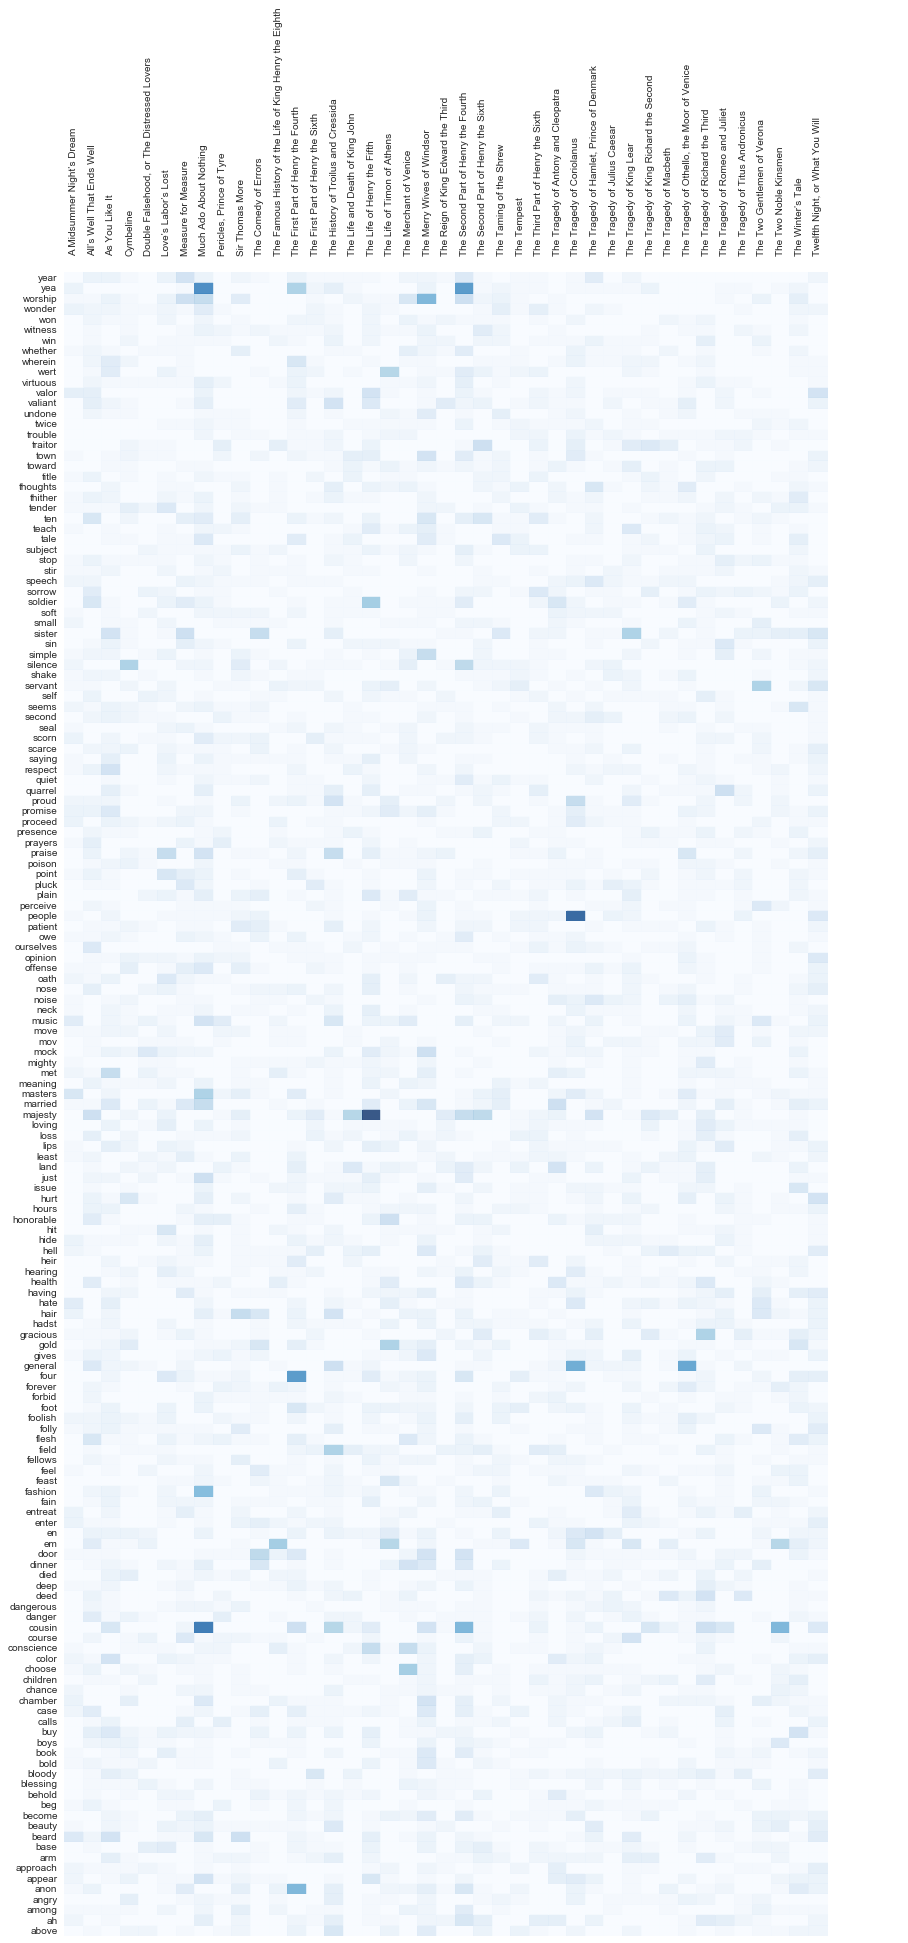

In [105]:
# 参考 http://nbviewer.jupyter.org/gist/joelotz/5427209
fig, ax = plt.subplots(figsize=(15,30))
heatmap = ax.pcolor(term_count.toarray().T, cmap=plt.cm.Blues, alpha=0.8)

ax.set_frame_on(False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(term_count.toarray().T.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(term_count.toarray().T.shape[1]) + 0.5, minor=False)

# add label
xlabel = plays_title #list of title
ylabel = count_vector.get_feature_names()
ax.set_xticklabels(xlabel, minor=False)
ax.set_yticklabels(ylabel, minor=False)

# rotate the x label
plt.xticks(rotation=90)

ax.grid(False)

# Turn off all the ticks
ax = plt.gca()

for t in ax.xaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False
for t in ax.yaxis.get_major_ticks():
    t.tick1On = False
    t.tick2On = False

In [76]:
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(term_count)

In [77]:
tfidf[1:10,1:10].toarray()

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.25858974,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0

In [79]:
tfidf.shape # 每一行为一个 document 也就是一句台词, 每一列为一个单词

(100731, 23182)

In [80]:
tfidf

<100731x23182 sparse matrix of type '<type 'numpy.float64'>'
	with 786176 stored elements in Compressed Sparse Row format>

In [85]:
print tfidf.max()

1.0


In [88]:
tfidf.todense(order='C').shape

(100731, 23182)

In [94]:
tfidf_vectorizer = TfidfVectorizer(max_features=200000,
                                 min_df=0.005, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
vec_tfidf = tfidf_vectorizer.fit_transform(X_all)
vec_tfidf.shape

(100731, 81)

In [95]:
tfidf_vectorizer.vocabulary_ # 觉得应该把一个play下的放一起....

{u'art': 0,
 u'away': 1,
 u'ay': 2,
 u'bear': 3,
 u'better': 4,
 u'blood': 5,
 u'brother': 6,
 u'come': 7,
 u'comes': 8,
 u'day': 9,
 u'dead': 10,
 u'death': 11,
 u'did': 12,
 u'doth': 13,
 u'duke': 14,
 u'er': 15,
 u'eyes': 16,
 u'fair': 17,
 u'father': 18,
 u'fear': 19,
 u'god': 20,
 u'good': 21,
 u'grace': 22,
 u'great': 23,
 u'hand': 24,
 u'hast': 25,
 u'hath': 26,
 u'head': 27,
 u'hear': 28,
 u'heart': 29,
 u'heaven': 30,
 u'honor': 31,
 u'king': 32,
 u'know': 33,
 u'lady': 34,
 u'leave': 35,
 u'let': 36,
 u'life': 37,
 u'like': 38,
 u'little': 39,
 u'live': 40,
 u'll': 41,
 u'long': 42,
 u'look': 43,
 u'lord': 44,
 u'love': 45,
 u'madam': 46,
 u'make': 47,
 u'man': 48,
 u'master': 49,
 u'men': 50,
 u'nay': 51,
 u'night': 52,
 u'noble': 53,
 u'old': 54,
 u'peace': 55,
 u'poor': 56,
 u'pray': 57,
 u'say': 58,
 u'shall': 59,
 u'sir': 60,
 u'son': 61,
 u'speak': 62,
 u'st': 63,
 u'stand': 64,
 u'sweet': 65,
 u'tell': 66,
 u'th': 67,
 u'thee': 68,
 u'thing': 69,
 u'think': 70,
 u'thou

In [113]:
for line in X_all[:10]:
    print line


In delivering my son from me, I bury a second husband.

And I in going, madam, weep o’er my father’s death anew; but I must attend his Majesty’s command, to whom I am now in ward, evermore in subjection.

You shall find of the King a husband, madam; you, sir, a father. He that so generally is at all times good must of necessity hold his virtue to you, whose worthiness would stir it up where it wanted rather than lack it where there is such abundance.

What hope is there of his Majesty’s amendment?

He hath abandon’d his physicians, madam, under whose practices he hath persecuted time with hope, and finds no other advantage in the process but only the losing of hope by time.

This young gentlewoman had a father—O, that “had,” how sad a passage ’tis!—whose skill was almost as great as his honesty; had it stretch’d so far, would have made nature immortal, and death should have play for lack of work. Would for the King’s sake he were living! I think it would be the death of the King’s dis

In [114]:
for line in X_all:
    with open('text.txt', 'a+') as f:
        f.write('\n'+line)

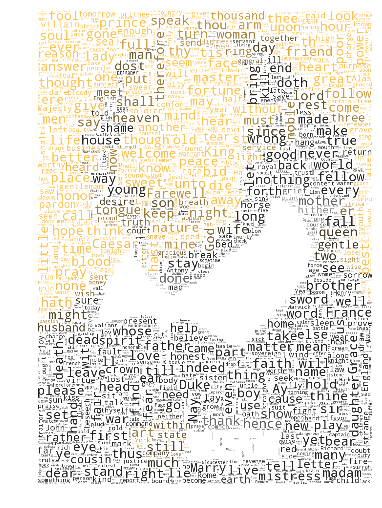

In [115]:
%run wc_poster.py